[View in Colaboratory](https://colab.research.google.com/github/akxkcd/fattails/blob/master/kalman_filter_exp_improve_params.ipynb)

In [0]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [0]:
# http://pytorch.org/
from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.3.0.post4-{platform}-linux_x86_64.whl torchvision
import torch

<h3> Generate Measurement Data <h3> 

In [0]:
import torch
from torch.autograd import Variable

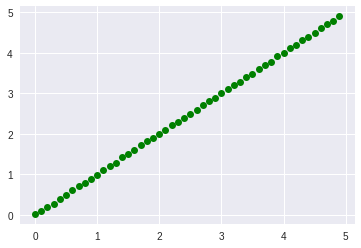

In [22]:
time_list = []
measurement_list = []
num_data = 50
dt = 0.1
for i in range(num_data):
  noise = np.random.normal(0, 0.01)
  time_list.append(i*dt)
  measurement_list.append(i*dt + noise)

plt.plot(time_list, measurement_list, 'go')
plt.show()

In [0]:
class kalman_filter():
  
  def __init__(self, q=0.1, r=0.1):
    self.state = torch.transpose(torch.Tensor([0., 0.]), -1, 0).view(2,1)
    self.P = torch.Tensor([[1., 0.], [0., 1.]])
    self.last_time = 0.
    # self.R = np.array([1])*r
    self.R = r
    # print(self.R)
    self.Q = torch.Tensor([[1., 0.], [0., 1.]])*q
    self.state_history = []
    self.P_history = []
    
  def update_time(self, cur_time):
    delta_t = cur_time - self.last_time
    self.last_time = cur_time
    
    F = torch.Tensor([[1., delta_t], [0., 1.]])
    # print("F:", F)
    # print("state:", self.state)
    self.state = torch.mm(F, self.state)
    self.P = torch.mm(torch.mm(F, self.P), torch.transpose(F, -1, 0)) + self.R
  
  def show(self):
    print("state:", self.state)
    print("P:", self.P)
    
  def update_measurement(self, measurement, display=False):
    measurement = torch.Tensor([measurement]).view(1,1)
    H = torch.Tensor([1., 0.]).view(1,2)
    # innovation
    # print("state:", self.state)
    
    y_k = measurement - torch.mm(H, self.state)
    if display:
      print("y_k", y_k)
    
    # innovation covariance
    var1 = torch.mm(torch.mm(H, self.P), torch.transpose(H, -1, 0))
    S_k = self.R + var1
    if display:
      print("S_k:", S_k)
    
    # kalman gain
    K_k = torch.mm(self.P, torch.transpose(H, -1, 0))/S_k
    if display:
      print("P:", self.P)
      print("H:", H)
      print("K_k:", K_k)
      
    # updated state
    state_delta = torch.mm(K_k, y_k)
    self.state = self.state + state_delta
    if display:
      print("updated state:", self.state)
      
    # updated covariance
    K_dot_H = 1. - torch.mm(H, K_k)
    # print("K_dot_H:", K_dot_H, torch.mm(K_k, H))
    # print(self.R.shape, self.R)
    p1 = torch.mm(torch.transpose(K_k, 0, -1), K_k)*self.R
    p2 = K_dot_H*K_dot_H*self.P
    # print("P2:", p2)
    # print("P1:", p1)
    # p2 = torch.mm(torch.mm(K_dot_H, self.P), torch.transpose(K_dot_H, 0, -1))
    self.P = p1 + p2
    if display:
      print("updated covariance:", self.P)
    
    self.state_history.append(self.state.numpy())
    self.P_history.append(self.P)

(50, 2, 1)
(2, 50) [[2.2975873e-02 7.1992867e-02 1.6419478e-01 2.4981621e-01 3.5558593e-01
  4.6019578e-01 5.7221383e-01 6.7798406e-01 7.6302320e-01 8.7285590e-01
  9.6819544e-01 1.0848855e+00 1.1950027e+00 1.2854272e+00 1.4008321e+00
  1.4923186e+00 1.5898492e+00 1.7024477e+00 1.8074294e+00 1.8973643e+00
  1.9958352e+00 2.0862396e+00 2.2008700e+00 2.2926908e+00 2.3931551e+00
  2.4946370e+00 2.5970793e+00 2.6997199e+00 2.8074512e+00 2.8959472e+00
  3.0072937e+00 3.1001225e+00 3.1994989e+00 3.2874274e+00 3.3923779e+00
  3.4819024e+00 3.5887399e+00 3.6933498e+00 3.7885711e+00 3.9061282e+00
  4.0034566e+00 4.1137738e+00 4.2085161e+00 4.3082061e+00 4.3966961e+00
  4.4986596e+00 4.6045890e+00 4.7035952e+00 4.7988577e+00 4.9034014e+00]
 [2.0887156e-03 4.7250688e-02 1.2966964e-01 1.9814727e-01 2.7914464e-01
  3.5141200e-01 4.2384928e-01 4.8357394e-01 5.1813722e-01 5.7280546e-01
  6.0866642e-01 6.6126585e-01 7.0271587e-01 7.2170490e-01 7.6244229e-01
  7.7680439e-01 7.9550815e-01 8.2664716e-01 

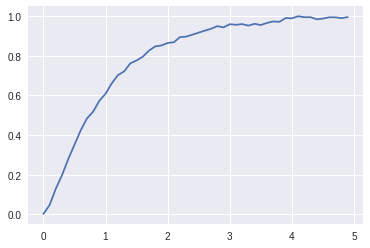

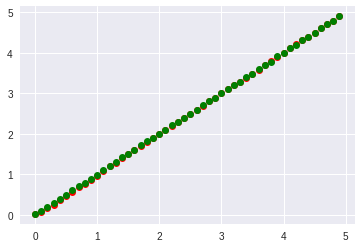

In [24]:

filter = kalman_filter()

for t, d in zip(time_list, measurement_list):
  filter.update_time(t)
  # filter.show()
  filter.update_measurement(d, False)

print(np.array(filter.state_history).shape)
states = np.array(filter.state_history).reshape(-1,2).T
print(states.shape, states)
plt.plot(time_list, states[1])
plt.show()
plt.plot(time_list, states[0], 'ro')
plt.plot(time_list, measurement_list, 'go')

In [0]:
class Model(torch.nn.Module):
  
  def __init__(self):
    super(Model, self).__init__()
    self.linear = torch.nn.Linear(1, 1)
    
  def forward(self, x):
    y_pred = self.linear(x)
    return y_pred
    

In [29]:
w = Variable(torch.Tensor([1.0]), requires_grad=True)
filter = kalman_filter(0.1, w)

for t, d in zip(time_list, measurement_list):
  filter.update_time(t)
  filter.update_measurement(d)

states = np.array(filter.state_history).T
plt.plot(time_list, states[1])
plt.show()
plt.plot(time_list, states[0], 'ro')
plt.plot(time_list, measurement_list, 'go')

Variable containing:
 1
[torch.FloatTensor of size 1]



RuntimeError: ignored